,aapl
Date,
2015-01-02,24.435272
2015-01-05,23.746885
2015-01-06,23.749128
2015-01-07,24.082140
2015-01-08,25.007421


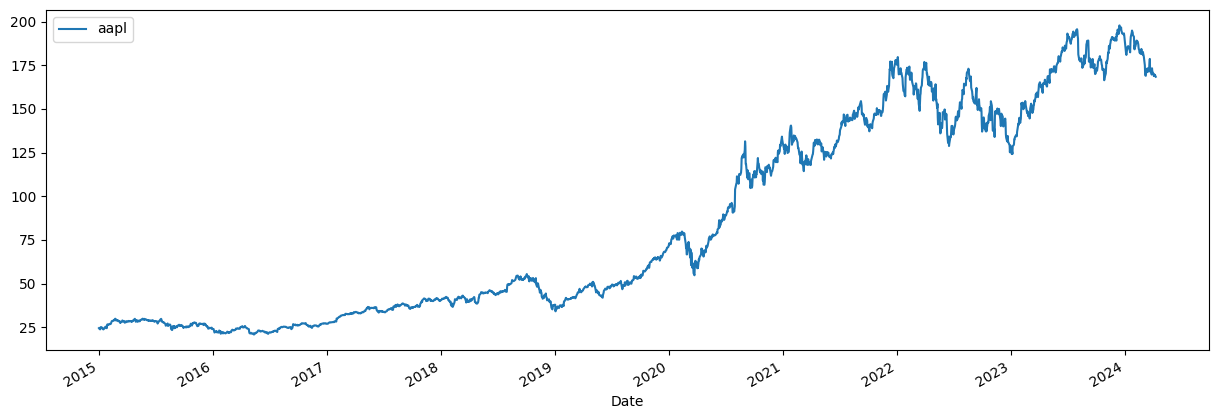

In [6]:
import bt
import pandas
import numpy as np
from scipy.stats import norm

data = bt.get('aapl', start='2015-01-01')
weights = np.array([1])
invested = 100000

plot = data.plot(figsize=(15,5), secondary_y=['target'])

data.head()

![alt text](VaR.png)

![alt text](PortfolioSD.png)

In [7]:
# Calculate percentage change (daily return)
percent_change = data.pct_change().dropna()

# Calculate portfolio returns for the last 'lookback' days
lookback = 100
portfolio_returns = percent_change.iloc[-lookback:].dot(weights)

# Function to calculate Value at Risk (VaR)
def calculate_var(alpha, invested, portfolio_returns):
    std = portfolio_returns.std()
    mean = portfolio_returns.mean()
    z_score = norm.ppf(1 - alpha)
    return -(mean + z_score * std) * invested

![alt text](CVaR.png)

In [8]:
def calculate_cvar(alpha, invested, portfolio_returns):
    # Calculate the Value at Risk (VaR) threshold
    var_threshold = np.percentile(portfolio_returns, alpha * 100)
    # Identify the returns that are worse than the VaR threshold
    tail_losses = portfolio_returns[portfolio_returns <= var_threshold]
    # Calculate the average of the losses beyond the VaR threshold
    expected_shortfall = tail_losses.mean()
    # Return the CVaR as a negative value (since it's a loss)
    return -invested * expected_shortfall


In [9]:
alpha = 0.05
CVaR = -abs(calculate_cvar(alpha, invested, portfolio_returns))
VaR = -abs(calculate_var(alpha, invested, portfolio_returns))

VaR_return = VaR / invested
CVaR_return = CVaR / invested

print(f"VaR (95% confidence): {VaR:.2f} USD")
print(f"CVaR (beyond 95% confidence): {CVaR:.2f} USD")

VaR (95% confidence): -1792.74 USD
CVaR (beyond 95% confidence): -2996.48 USD


Visualisation of results

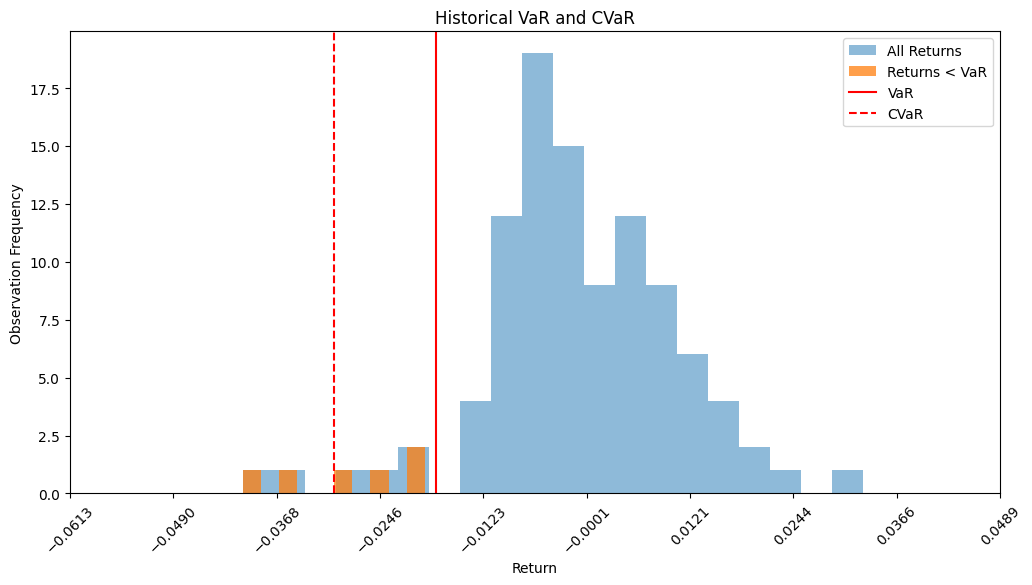

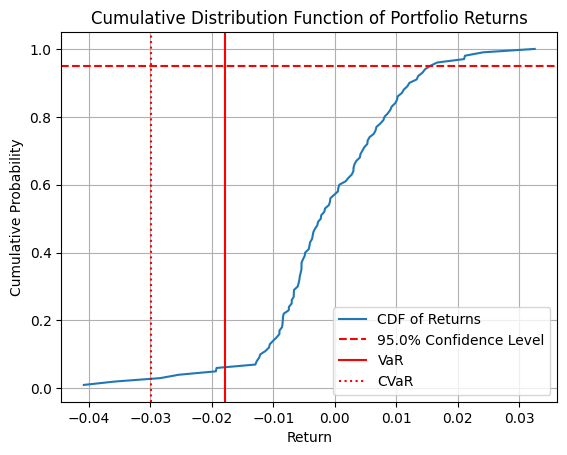

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=100)

# Plot the distribution of portfolio returns
plt.hist(portfolio_returns, bins=20, alpha=0.5, label='All Returns')

# Highlight the returns below VaR
plt.hist(portfolio_returns[portfolio_returns < VaR_return], bins=10, alpha=0.75, label='Returns < VaR')

# Mark VaR and CVaR on the plot
plt.axvline(VaR_return, color='red', linestyle='solid', label='VaR')
plt.axvline(CVaR_return, color='red', linestyle='dashed', label='CVaR')

plt.legend()
plt.title('Historical VaR and CVaR')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')


# Adjusting x-axis to zoom in closer to the data
plt.xlim(left=np.min(portfolio_returns)*1.5, right=np.max(portfolio_returns)*1.5)

# Customizing tick labels to show more precision
plt.xticks(np.linspace(np.min(portfolio_returns)*1.5, np.max(portfolio_returns)*1.5, num=10), rotation=45)


plt.show()
# Plotting the CDF
sorted_returns = np.sort(portfolio_returns)
cumulative_probs = np.arange(1, len(sorted_returns)+1) / len(sorted_returns)
plt.plot(sorted_returns, cumulative_probs, label='CDF of Returns')
plt.axhline(y=1-alpha, color='r', linestyle='dashed', label=f'{100*(1-alpha)}% Confidence Level')
plt.axvline(x=VaR_return, color='r', linestyle='solid', label='VaR')
plt.axvline(x=CVaR_return, color='r', linestyle='dotted', label='CVaR')
plt.title('Cumulative Distribution Function of Portfolio Returns')
plt.xlabel('Return')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()
